# Demo of VAE for anomaly detection of diverse sensor data
Trained on non-valve fault data to learn a normal expectation.

Build the model for 512 time points per cycle with 14 sensors.

In [1]:
%matplotlib inline

In [2]:
from IPython.core.debugger import set_trace

In [3]:
from demo import *
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
model = VAE1D(size, n_channels, n_latent)
model = model.to(device)
print(f"Time-series size = {size}, number of sensors = {n_channels}, "
      f"latent size = {n_latent}")

Time-series size = 512, number of sensors = 14, latent size = 50


Load the best parameters from training.

In [5]:
model = load_checkpoint(model, device)

Checkpoint Performance:
Validation loss: 6.514
Epoch: 95


In [6]:
params = model.demo()

Input size: torch.Size([1, 14, 512])
Encoded size: torch.Size([1, 1024, 4])
Latent size: torch.Size([1, 50, 1])
Decoded (output) size: torch.Size([1, 14, 512])


In [21]:
X, E, L, D = [param.cpu().detach().numpy() for param in params]
MSE = np.power((X - D), 2).sum() / 2
print(f"MSE of random data = {MSE:.3f}")

MSE of random data = 22358.824


In [30]:
X[:, :4, :4]

array([[[0.64495915, 0.9520661 , 0.30107006, 0.44056106],
        [0.8329663 , 0.358087  , 0.58229834, 0.44558325],
        [0.29576135, 0.6134356 , 0.93747485, 0.9023328 ],
        [0.41530746, 0.36178476, 0.1554705 , 0.874464  ]]], dtype=float32)

In [29]:
D[:, :4, :4]

array([[[-1.8892716 , -1.7976729 , -0.9980914 , -0.90417683],
        [-2.179412  , -5.3462014 , -5.082779  , -4.1110272 ],
        [-0.6492111 , -0.5677223 , -0.6769047 ,  0.06160915],
        [-1.0232391 , -0.96922624, -0.10261436,  0.11870949]]],
      dtype=float32)

Next we need to load the datasets of sensors readings.

In [31]:
data_path = Path('data/hydraulic')
train_dl, val_dl, test_dl = load_datasets(data_path)

In [32]:
print(len(train_dl), len(val_dl), len(test_dl))

38 10 720


Let's get some random samples from the dataset for examples and generate new versions.

In [33]:
data, targets = get_random_samples(test_dl)

In [34]:
list_target_classes(test_dl)

0 = fail
1 = norm


In [35]:
targets = targets.cpu().numpy()
targets

array([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1])

In [36]:
criterion = VAE1DLoss()
criterion = criterion.to(device)

In [37]:
model.eval()
with torch.no_grad():
    # Generate
    data = data.to(device)
    gen_data, mu, logvar = model(data)
    loss, loss_desc = criterion(gen_data, data, mu, logvar, reduce=False)
    

In [38]:
gen_err = -loss_desc['logp']
gen_err

tensor([20778.0664, 23282.3457, 22760.8828, 23741.4746, 27966.3184, 24592.3633,
        12246.5205, 28761.2559, 12016.1875, 19786.2578, 19179.2402, 14809.8682,
        23416.7305, 12264.8613, 23609.4844, 23169.5703, 12185.7773, 12212.9824,
        12080.6309, 12090.9590], device='cuda:0')

[[ 1.8802063   2.300041    1.6247741   1.620625    1.3480793 ]
 [ 1.8363461   4.7919025   4.333598    4.5290895   3.569889  ]
 [ 1.6530236   2.388736    2.146257    1.8306111   1.626546  ]
 [ 1.2182692   1.1586286   0.516746    0.17714816 -0.4307298 ]
 [ 0.47544003  3.3044038   3.421551    3.198757    3.8189077 ]]
MSE = 20778.06640625


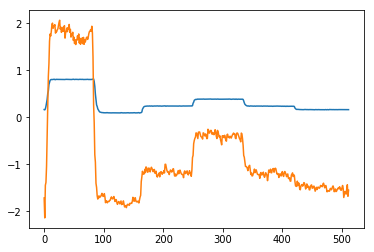

In [39]:
idx = 0
sample = data[idx, :, :].cpu().numpy()
gen_sample = gen_data[idx, :, :].cpu().numpy()
plt.plot(sample[0, :])
plt.plot(gen_sample[0, :])
print(sample[:5, :5] - gen_sample[:5, :5])
print(f"MSE = {np.power((sample - gen_sample), 2).sum() / 2}")

[[ 0.8983066   0.856858    0.8947829   0.7956577   0.36355618]
 [ 1.3982705   3.2973752   3.2870278   3.876343    3.6591523 ]
 [-0.54235005 -1.1194918  -0.61374307 -0.27401477 -0.4182222 ]
 [ 0.8980919   0.60820293  0.17434251 -0.19951004 -0.7401475 ]
 [ 0.2834887   1.7944818   2.462849    2.7346363   2.5468895 ]]
MSE = 23282.34375


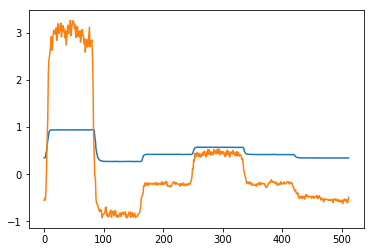

In [40]:
idx = 1
sample = data[idx, :, :].cpu().numpy()
gen_sample = gen_data[idx, :, :].cpu().numpy()
plt.plot(sample[0, :])
plt.plot(gen_sample[0, :])
print(sample[:5, :5] - gen_sample[:5, :5])
print(f"MSE = {np.power((sample - gen_sample), 2).sum() / 2}")

In [43]:
err = np.zeros(targets.shape)
for i, target in enumerate(targets):
    err[i] = -loss_desc['logp'][i]
    print(f"Target = {target}, MSE = {err[i]:.3f}")

Target = 0, MSE = 20778.066
Target = 0, MSE = 23282.346
Target = 0, MSE = 22760.883
Target = 0, MSE = 23741.475
Target = 0, MSE = 27966.318
Target = 1, MSE = 24592.363
Target = 0, MSE = 12246.521
Target = 0, MSE = 28761.256
Target = 1, MSE = 12016.188
Target = 0, MSE = 19786.258
Target = 0, MSE = 19179.240
Target = 0, MSE = 14809.868
Target = 0, MSE = 23416.730
Target = 1, MSE = 12264.861
Target = 0, MSE = 23609.484
Target = 0, MSE = 23169.570
Target = 0, MSE = 12185.777
Target = 0, MSE = 12212.982
Target = 0, MSE = 12080.631
Target = 1, MSE = 12090.959


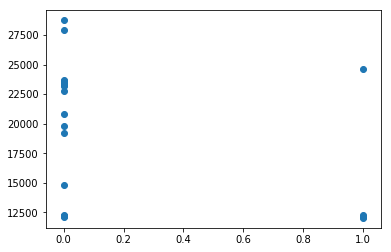

In [44]:
plt.scatter(targets, err)

Show the data plots.

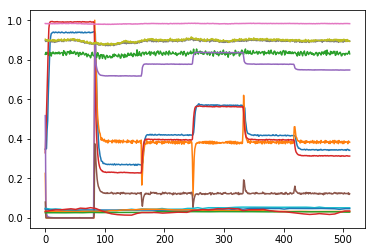

In [45]:
show_plot(sample)

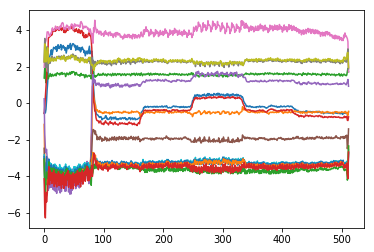

In [46]:
show_plot(gen_sample)

Let's score the success of the recreation and look for outliers.

In [47]:
def compute_scores(X, model, criterion):
    assert X.shape[0] == 1, "Must compute score for one sample at a time"
    X_hat, mu, logvar = model(X)
    loss, loss_desc = criterion(X_hat, X, mu, logvar, reduce=False)
    score = {'loss': loss.item(),
             'KL': loss_desc['KL'].item(),
             'error': -loss_desc['logp'].item()}
    return score

def score(dl):
    score_names = ['loss', 'KL', 'error']
    classes = dl.dataset.classes
    scores = {(name, cls): [] for name in score_names for cls in classes}
    
    model.eval()
    with torch.no_grad():
        for i, (X, y) in enumerate(tqdm(dl)):
            X = X.to(device)
            for j in range(X.shape[0]):
                data = X[j, :].unsqueeze(0)
                cls = classes[y[j].item()]
                score = compute_scores(data, model, criterion)
                for name in score_names:
                    scores[(name, cls)].append(score[name])
    return scores

In [48]:
scores = score(test_dl)

100%|██████████| 720/720 [00:04<00:00, 158.11it/s]


In [49]:
test_means = pd.DataFrame()
for (name, cls), item in scores.items():
    test_means.loc[name, cls] = np.array(item).mean()

print("###################### TEST MEANS #####################")
print(test_means)

###################### TEST MEANS #####################
               fail          norm
loss   18274.414781  16843.840929
KL        46.158913     42.563042
error  18228.255919  16801.277903


In [50]:
val_means = pd.DataFrame()
for (name, cls), item in score(val_dl).items():
    val_means.loc[name, cls] = np.array(item).mean()

print("###################### VAL MEANS #####################")
print(val_means)

100%|██████████| 10/10 [00:01<00:00,  5.23it/s]

###################### VAL MEANS #####################
               norm
loss   17787.540917
KL        45.057070
error  17742.483862


In [51]:
train_means = pd.DataFrame()
for (name, cls), item in score(train_dl).items():
    train_means.loc[name, cls] = np.array(item).mean()

print("###################### VAL MEANS #####################")
print(train_means)

100%|██████████| 38/38 [00:06<00:00,  5.80it/s]

###################### VAL MEANS #####################
               norm
loss   17886.779055
KL        46.032194
error  17840.746850
